In [287]:
import geopandas as gp
import pandas as pd
import os
import json
import pylab as pl
#s = json.load( open(os.getenv('PUI2015')+'/fbb_matplotlibrc.json') )
#pl.rcParams.update(s)
%pylab inline



Populating the interactive namespace from numpy and matplotlib


I am using geopandas. that is **not required** for this particular exercise, but geopandas works with geospacial data: the shape files that we get from pluto for example.

PLEASE REMEMBER: seed your random functions if you need to use any, label your axes clearly, comment your code, use PEP8!


##We will use 2 different datasets.
##an interesting urban question is "can we measure and predict energy use based on observables that are easier to be acquired". for example the urban observatory at CUSP can monitor lights: they are a realtively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.
##so let's test if the last link holds. If we have data on the energy consumed by a __building__ how well does that relate to the number of units in the building?

## data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  

In [288]:
nrg = gp.GeoDataFrame.from_csv("Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")
print nrg.columns

Index([u'NYC Borough, Block, and Lot (BBL)', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'],
      dtype='object')


#however this datasets does not have the number of units. We can find that in the Pluto dataset.
reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp

In [289]:
bsize = gp.GeoDataFrame.from_file("Manhattan/MNMapPLUTO.shp")
print bsize.columns

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

in pandas scatter_matrix will plot each column agains each other. that is a great way to begin inspecting your data (though be careful cause it is computationally comsuming for large datasets) 



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000018AD9DD8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000003235A0F0>]], dtype=object)

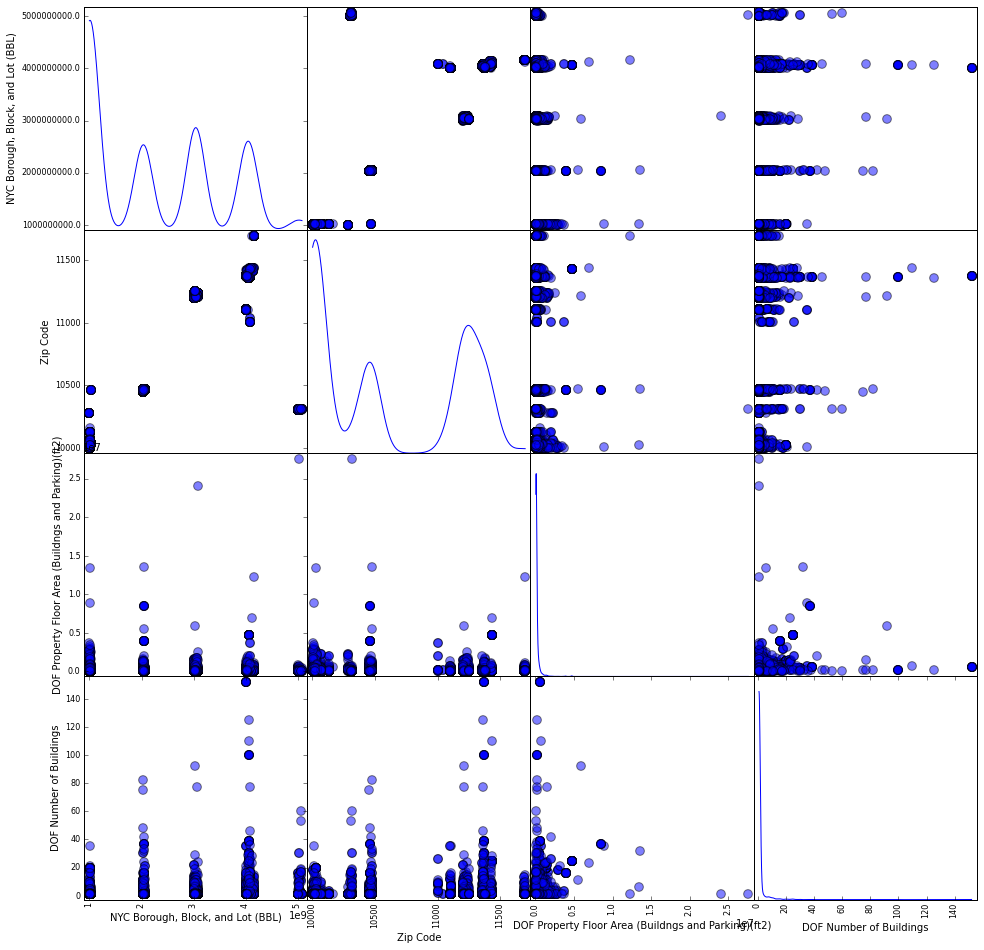

In [290]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16), diagonal='kde')

it will show me correlations between variables, but it will also show me what can and 
cannot be plotted trivially in my dataset! here only a few columns can be plotted: 
those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. 
The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg.       u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: i need to remove all values that cannot conver to float in order to use the columns and convert them to float arrays and do math with them. 

Below I created a function that returns True if what is passed as argument can be converted to a float, and False otherwise. I do it with the Try/Except structure. it is a very useful python functionality that you should look into.  
this has to be done entry by entry: if you gve t a series you get error "cannot convert the series to <type 'float'>"

However you can pass it a whole array by using it in conjunction with
np.vectorize (look up the syntax!) which will implement a for loop for you under the hood to pass the series entry by entry to your function.


In [291]:
def canconvert(mydata):
    try :
        float(mydata)
        return True
    except ValueError:
        return False

convertfunc = np.vectorize(canconvert)

Now for every column i care about i can create an array, call it for eg. indx, of True and False (a Boolean array) that i can use as an index to pick entries that 
I want to use from my arrays of interest. I can replace the entries that failed to be converted to 'NaN'

(because my function return Trues when I can convert and False otherwise i actuallly want the complementary array: ~indx)

In [292]:
#create the indeces array here
indx = (convertfunc(nrg['Site EUI(kBtu/ft2)']) & convertfunc(nrg['Reported Property Floor Area (Building(s)) (ft²)']))==True

In [293]:
nrg['Site EUI(kBtu/ft2)'][~indx] = float('NaN')
nrg['Reported Property Floor Area (Building(s)) (ft²)'][~indx] = float('NaN')

print "Number of NaN's in 'Site EUI(kBtu/ft2)' column: ", nrg['Site EUI(kBtu/ft2)'][~indx].astype(float).isnull().sum()
print "Number of NaN's in 'Reported Property Floor Area (Building(s)) (ft²)' column: ", nrg['Reported Property Floor Area (Building(s)) (ft²)'][~indx].astype(float).isnull().sum()
##etc etc... for all columns you care about

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


Number of NaN's in 'Site EUI(kBtu/ft2)' column:  740
Number of NaN's in 'Reported Property Floor Area (Building(s)) (ft²)' column:  740


In [294]:
##check that your conversion worked: e.g.
print nrg['Site EUI(kBtu/ft2)'].astype(float)
print nrg['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)
#[...] check all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want
print bsize.BBL.astype(float)
#notice i can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!

Record Number
16099      180.5
500         82.1
5017       137.7
5116       103.2
363         74.0
6876        36.4
10714      114.8
1214       130.0
1544       138.3
1905     56909.0
2301        88.2
15059       15.7
674          NaN
2537        85.7
2841       195.7
2945        79.1
15120      144.1
3053       200.9
4233       104.6
4777        86.7
4912       102.1
5210        21.2
5295        78.3
1575         NaN
15025       55.2
4208        83.2
4799       145.1
1568        59.4
5427        88.7
5476       100.8
          ...   
14559        NaN
14560        NaN
14748        NaN
14753        NaN
13582        NaN
13947        NaN
14777        NaN
14779        NaN
14409        NaN
13262        NaN
13261        NaN
12523        NaN
12529        NaN
12536        NaN
13929        NaN
13944        NaN
13945        NaN
13821        NaN
13829        NaN
13837        NaN
13838        NaN
13847        NaN
14352        NaN
12976        NaN
12978        NaN
12984        NaN
12987        NaN


#TO MERGE THE DATASET WE NEED A COMMON COLUMN
here is where you want to merge the datasets. You need a common column: the building id BBL
However the name of this variable (column) in the Energy dataset is     'NYC Borough, Block, and Lot (BBL)'. create a column 'BBL' in the nrg dataset to pass it to the 'on' keyword argument of the merge pandas method: pd.merge(..... on=['BBL']) will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!) 

In [295]:
nrg['BBL'] = nrg['NYC Borough, Block, and Lot (BBL)']
bblnrgdata = pd.merge(nrg,bsize,on=['BBL'])
bblnrgdata.columns

Index([                  u'NYC Borough, Block, and Lot (BBL)',
                                    u'Co-reported BBL Status',
                                          u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
                                             u'Street Number',
                                               u'Street Name',
                                                 u'Borough_x',
                                                  u'Zip Code',
                        u'DOF Benchmarking Submission Status',
                                        u'Site EUI(kBtu/ft2)', 
       ...
                                                u'YearAlter2',
                                                 u'YearBuilt',
                                                    u'ZMCode',
                                                   u'ZipCode',
                                                 u'ZoneDist1',
                                           

once you have the dataframe with all the info you want, you want to plot 
Energy vs Number of Units in the Building. 
Remember: Energy TOTAL, not per sq ft...
Here you can choose what you think makes more sense for the number of units: all units, residential units...
make a 'natural' scale scatter plot first it will look really bad cause all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000.
perhaps zoom into the region where most points are by cutting your x and y axis plotted: e,g, use xlim=(1000,1e10), ylim=(1,1000), where the numbers to be plugged in depend on exactly what you chose to plot

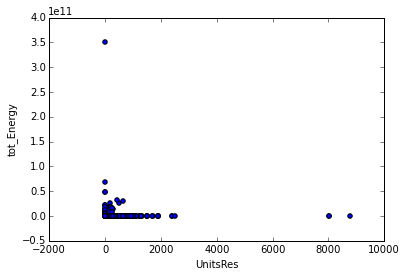

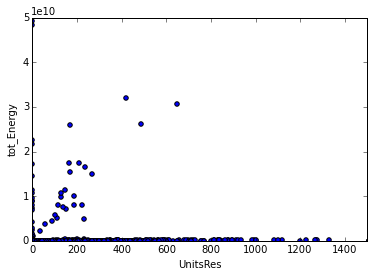

In [296]:
# Energy vs Number of Units in the Building make a 'natural' scale scatter plot first
a = np.array((bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)']),dtype=float)
b = np.array(bblnrgdata['Site EUI(kBtu/ft2)'],dtype=float)
bblnrgdata['tot_Energy'] = a * b
bblnrgdata.plot(kind='scatter', x='UnitsRes', y='tot_Energy')
#bblnrgdata.plot(kind='scatter', x='UnitsTotal', y='tot_Energy')

# perhaps zoom into the region where most points are by cutting your x and y axis plotted: e,g, use
bblnrgdata.plot(kind='scatter', x='UnitsRes', y='tot_Energy',xlim=(0,1500), ylim=(100,0.5e11))


when the points in a plot all look scrunched against the axis try a log plot! in pandas you enable that with the keyword 'loglog' :
bblnrgdata.plot(..... loglog=True)

NOTICE THAT YOU WILL STILL HAVE TO CUT YOUR DATASET! in my data i had a lot of energy datapoints that were exactly 0. I removed these "outliers" which I think are truly outliers in the sense that they are misreported numbers. you can remove the data that have nrg==0 (or nrg < some sensible threshold choice) by indexing your array:
something like bblnrgdata_cut = bblnrgdata[bblnrgdata.nrg>1000]

also i removed the buildings with several thousand units. points like that at the edge of my range would have a lot of "LEVERAGE", however  they are not suprious entries like the 0, which i believe are missing values, or perhaps abandoned lots. these are good datapoint that i need to throw away functionally for my analysis to work, but that should be stated clearly.


In [300]:
#NOTICE THAT YOU WILL STILL HAVE TO CUT YOUR DATASET! 
bblnrgdata_cut = bblnrgdata[(bblnrgdata.tot_Energy>1000) & (bblnrgdata.tot_Energy<1e11) & (bblnrgdata.UnitsRes>10) &(bblnrgdata.UnitsRes<1000)]

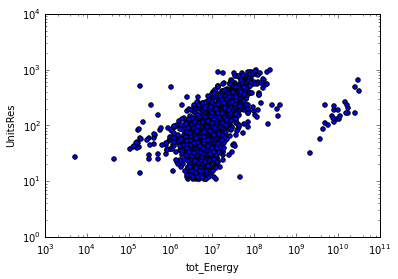

In [301]:
# Try a log plot
bblnrgdata_cut.plot(kind="scatter", x='tot_Energy', y='UnitsRes',loglog=True)

Now fit a line through the data. you can use whatever you want to do it: 
statsmodels, scipy, any other package, or write your own minimization of the residuals
## BUT REMEMBER: we see hints of a lienar relation in log space! so we want to fit a line to the log of our variables, not the variables themselves:

if you used statsmodels it would look something like this:

In [326]:
import statsmodels.api as sm
def ft1(x,y):
    X = sm.tools.add_constant(x)
    model = sm.regression.linear_model.OLS(y, X, missing='drop') # ignores entires where x or y is NaN
    fit = model.fit()
    return fit.params[1], fit.params[0], fit # could also return stderr in each via fit.bse


try making a fit for energy vs units AND a fit for units vs energy. 
tell me which is better. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             tot_Energy   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     1889.
Date:                Fri, 16 Oct 2015   Prob (F-statistic):               0.00
Time:                        16:24:21   Log-Likelihood:                -1448.9
No. Observations:                3445   AIC:                             2902.
Df Residuals:                    3443   BIC:                             2914.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          5.5097      0.035    158.633      0.000         5.442     5.578
UnitsRes       0.7591      0.017     43.458      0.000         0.725     0.793
==============================================================================
Omnibus:                     2164.036   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           102012.492
Skew:                           2.341   Prob(JB):                         0.00
Kurtosis:                      29.244   Cond. No.                         13.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

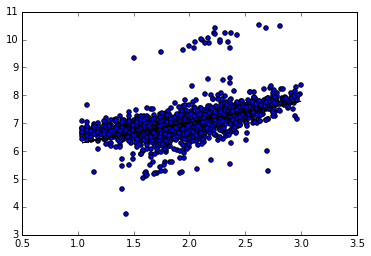

In [332]:
c1,c2,mdl1 = ft1(x=np.log10(bblnrgdata_cut.UnitsRes),y=np.log10(bblnrgdata_cut.tot_Energy)) 
pl.scatter(x=np.log10(bblnrgdata_cut.UnitsRes), y=np.log10(bblnrgdata_cut.tot_Energy))
plot(np.log10(bblnrgdata_cut.UnitsRes), mdl1.predict(), 'k')
mdl.summary()

In [ ]:
#answer the question here

##now fit a second degree curve to it: a*x^2+b*x+c. 
that is still called a linear fir by the way, the "linear" definition refers to the PARAMETERS being linear, not to the variable!
you can use np.polyfit for example (an example showned in the other assignment notebook), with order 2 instead of 1,

np.polyfit(x, y, 2)

or statmodels.formula.api passing a formula like 

formula = 'y ~ 1 + x + I(x ^ 2.0)'

##look at the fit summary: which is better? could you do a likelihood ratio test here? why or why not??

In [353]:
import statsmodels.formula.api as smf
def ft2(x,y):
    cf = np.polyfit(x, y, 2)
    return cf

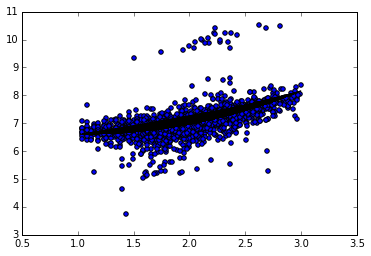

In [355]:
mdl2 = ft2(x=np.log10(bblnrgdata_cut.UnitsRes),y=np.log10(bblnrgdata_cut.tot_Energy)) 
p = np.poly1d(mdl2)
pl.scatter(x=np.log10(bblnrgdata_cut.UnitsRes), y=np.log10(bblnrgdata_cut.tot_Energy))
plot(np.log10(bblnrgdata_cut.UnitsRes), p(np.log10(bblnrgdata_cut.UnitsRes)), 'k')
#mdl.summary()